NAME : VISHAL KUMAR

ROLL NO : 23M1085

                                ASSIGNMENT-03

In [ ]:
import requests
import zipfile
import os

# URL of the dataset
url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

# Download the zip file
zip_file_path = "./hymenoptera_data.zip"
with open(zip_file_path, "wb") as f:
    response = requests.get(url)
    f.write(response.content)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("./")

# Remove the zip file after extraction
os.remove(zip_file_path)

# Now the data is downloaded and extracted into the directory "hymenoptera_data"


In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load dataset
data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(root=data_dir, transform=data_transforms[x]) for x in ['train']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train']}

# Load pre-trained ResNet-18 model
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1]))  # Remove the final fully connected layer

# Extract features
def extract_features(model, dataloader):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels_batch in dataloader:
            features_batch = model(inputs)
            features.append(features_batch)
            labels.append(labels_batch)
    return torch.cat(features), torch.cat(labels)

# Extract features for the training data
features, labels = extract_features(resnet18, dataloaders['train'])


# Now you have features and labels, you can visualize them, pre-process further, or proceed to clustering.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can als

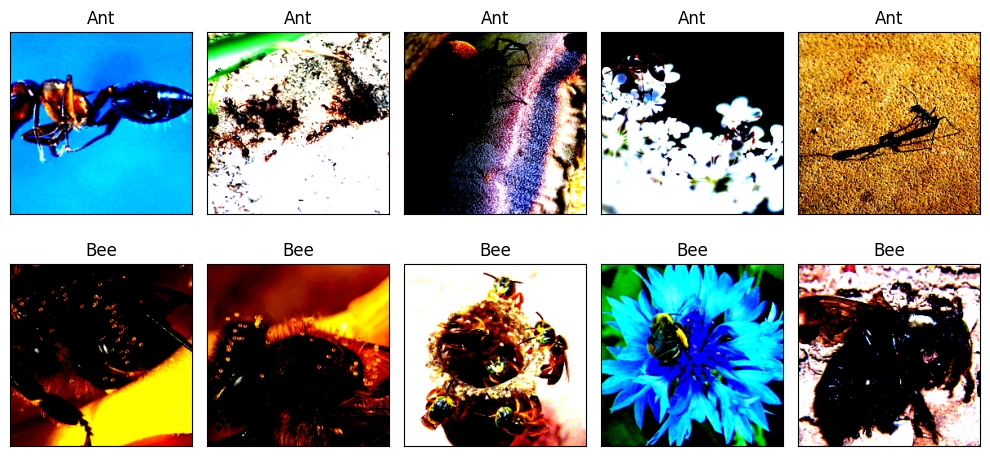

In [ ]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Directory where the data is extracted
data_dir = '/content/hymenoptera_data'

# Load dataset
image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train']}

# Get the indices of ants and bees
ant_indices = [idx for idx, label in enumerate(image_datasets['train'].targets) if label == 0]
bee_indices = [idx for idx, label in enumerate(image_datasets['train'].targets) if label == 1]

# Function to visualize images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Visualize five images of ants and five images of bees in two rows
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Visualize five images of ants
for i in range(5):
    ax = axes[0, i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image_datasets['train'][ant_indices[i]][0].permute(1, 2, 0))
    ax.set_title('Ant')

# Visualize five images of bees
for i in range(5):
    ax = axes[1, i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image_datasets['train'][bee_indices[i]][0].permute(1, 2, 0))
    ax.set_title('Bee')

plt.tight_layout()
plt.show()


Here we visualize the 5 images of ants and 5 images of bees.Now we will move forward to the pre processing part.

**Preprocessing**

In [ ]:
from sklearn.preprocessing import StandardScaler

# Reshape features to 2D array
num_samples, num_features = features.shape[0], np.prod(features.shape[1:])
features_reshaped = features.reshape(num_samples, num_features)

# Normalize features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_reshaped)

# Define features_array
features_array = features_normalized


In [ ]:
print(features.shape)
print(features_array.shape)

torch.Size([397, 512, 1, 1])
(397, 512)


# **PART(b)**



First we train k-means then we are trying to find the silhhouette score

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
# Train KMeans with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(features_normalized)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

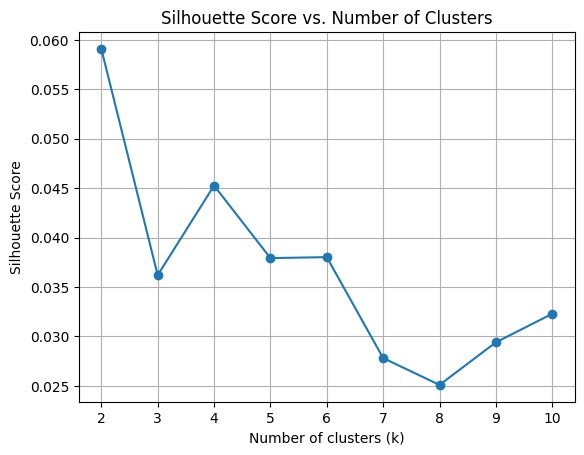

Optimal number of clusters (k): 2


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Function to determine the appropriate number of clusters using silhouette method
def find_optimal_k(features):
    silhouette_scores = []
    ks = range(2, 11)  # Trying different values of k from 2 to 10
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(features)
        silhouette_avg = silhouette_score(features, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    return ks, silhouette_scores

# Find the appropriate number of clusters
ks, silhouette_scores = find_optimal_k(features_normalized)

# Plot silhouette scores
plt.plot(ks, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

# Based on the plot, you can choose the optimal number of clusters with the highest silhouette score
optimal_k = ks[np.argmax(silhouette_scores)]
print("Optimal number of clusters (k):", optimal_k)


Observation: As we can see from the graph the most optimal number of clusters is 2 and the Silhohouette score is 0.059.

PART C

Cluster 0: Number of samples = 201
Length of image dataset: 244
Sampled indices for Cluster 0: [271, 232, 131, 180]
Cluster 1: Number of samples = 196
Length of image dataset: 244
Sampled indices for Cluster 1: [60, 340, 87, 202]


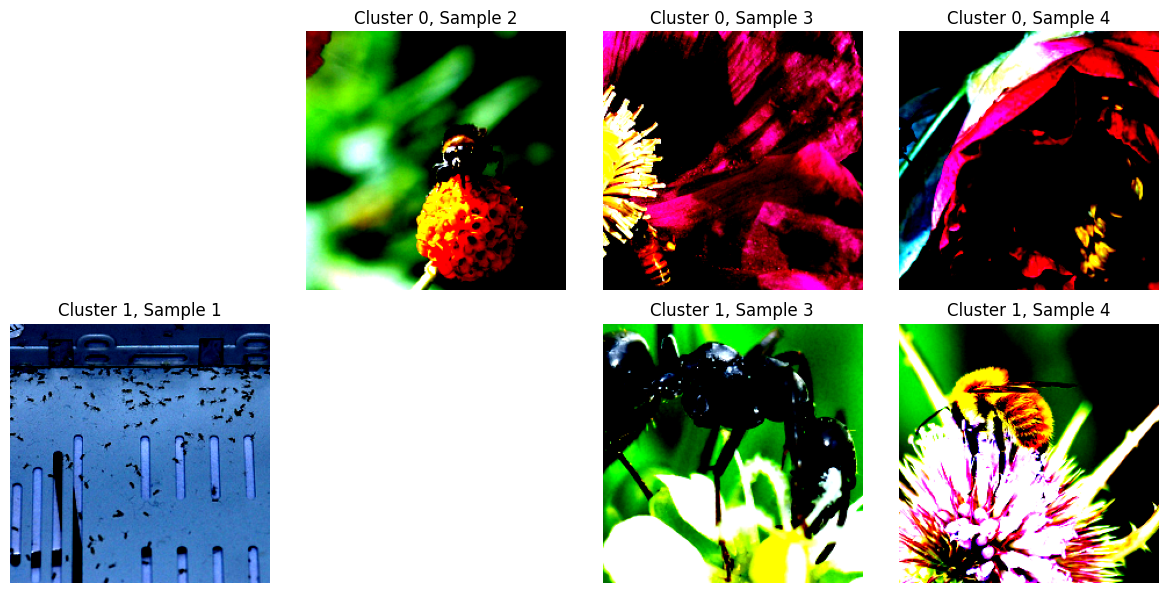

In [ ]:
# Visualize a few samples from each cluster
num_samples_per_cluster = 4  # Number of samples to visualize from each cluster
plt.figure(figsize=(12, 6))
for cluster, indices in cluster_indices.items():
    print(f"Cluster {cluster}: Number of samples = {len(indices)}")  # Debugging
    print(f"Length of image dataset: {len(image_datasets['train'])}")  # Debugging
    if len(indices) >= num_samples_per_cluster:  # Check if there are enough samples in the cluster
        sample_indices = random.sample(indices, num_samples_per_cluster)
        print(f"Sampled indices for Cluster {cluster}: {sample_indices}")  # Debugging
        for i, sample_idx in enumerate(sample_indices):
            if sample_idx < len(image_datasets['train']):  # Check if the sampled index is within range
                sample = image_datasets['train'][sample_idx]
                plt.subplot(2, num_samples_per_cluster, i + 1 + cluster * num_samples_per_cluster)
                plt.imshow(sample[0].permute(1, 2, 0))  # Display the image
                plt.title(f"Cluster {cluster}, Sample {i+1}")
                plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
print("Sampled indices:", sample_indices)


Sampled indices: [60, 340, 87, 202]


PART D

Now we will

In [ ]:
# Count the number of ants and bees in each cluster
ant_counts = {cluster: sum(1 for idx in indices if idx in ant_indices) for cluster, indices in cluster_indices.items()}
bee_counts = {cluster: sum(1 for idx in indices if idx in bee_indices) for cluster, indices in cluster_indices.items()}

# Determine the majority class for each cluster
cluster_majority_class = {cluster: 'ant' if ant_counts[cluster] > bee_counts[cluster] else 'bee' for cluster in cluster_indices}

# Calculate purity for each cluster
cluster_purity = {cluster: max(ant_counts[cluster], bee_counts[cluster]) / len(cluster_indices[cluster]) for cluster in cluster_indices}

# Print cluster purity
for cluster, purity in cluster_purity.items():
    print(f"Cluster {cluster}: Purity = {purity:.2f} (Predominantly {cluster_majority_class[cluster]})")


Cluster 0: Purity = 0.31 (Predominantly bee)
Cluster 1: Purity = 0.34 (Predominantly ant)


OBSERVATION : We see that Cluster 0 is predominantly associated with bees, with a purity of 0.31, meaning around 31% of the samples in this cluster are bees.

 On the other hand, Cluster 1 is predominantly associated with ants, with a slightly higher purity of 0.34, indicating that around 34% of the samples in this cluster are ants.

 Also we observe that Cluster 1 has a slightly higher purity compared to Cluster 0, indicating that it contains a higher proportion of ants relative to bees.


PART E

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# Define a range of values for MinPts and ε
min_pts_values = [3, 5, 10, 15 , 20 , 25]  # Example values for MinPts
epsilon_values = [20, 25, 22,30 ,28 ]  # Example values for ε

# Iterate over combinations of MinPts and ε
for min_pts in min_pts_values:
    for epsilon in epsilon_values:
        # Train DBSCAN with current parameters
        dbscan = DBSCAN(eps=epsilon, min_samples=min_pts)
        cluster_labels = dbscan.fit_predict(features_normalized)

        # Count the number of clusters (excluding noise)
        num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

        print(f"MinPts = {min_pts}, ε = {epsilon}: Number of clusters = {num_clusters}")


MinPts = 3, ε = 20: Number of clusters = 3
MinPts = 3, ε = 25: Number of clusters = 1
MinPts = 3, ε = 22: Number of clusters = 2
MinPts = 3, ε = 30: Number of clusters = 1
MinPts = 3, ε = 28: Number of clusters = 1
MinPts = 5, ε = 20: Number of clusters = 3
MinPts = 5, ε = 25: Number of clusters = 1
MinPts = 5, ε = 22: Number of clusters = 1
MinPts = 5, ε = 30: Number of clusters = 1
MinPts = 5, ε = 28: Number of clusters = 1
MinPts = 10, ε = 20: Number of clusters = 0
MinPts = 10, ε = 25: Number of clusters = 1
MinPts = 10, ε = 22: Number of clusters = 2
MinPts = 10, ε = 30: Number of clusters = 1
MinPts = 10, ε = 28: Number of clusters = 1
MinPts = 15, ε = 20: Number of clusters = 0
MinPts = 15, ε = 25: Number of clusters = 1
MinPts = 15, ε = 22: Number of clusters = 2
MinPts = 15, ε = 30: Number of clusters = 1
MinPts = 15, ε = 28: Number of clusters = 1
MinPts = 20, ε = 20: Number of clusters = 0
MinPts = 20, ε = 25: Number of clusters = 1
MinPts = 20, ε = 22: Number of clusters = 

We will consider the min points and epsilon value corresponding to K=2 as it was optimal no. of cluster giving the best Silhouette Score as we saw in above part

In [ ]:
from sklearn.cluster import DBSCAN

# Define the optimal MinPts and ε values
min_pts = 10
epsilon = 22

# Train DBSCAN with the optimal parameters
dbscan = DBSCAN(eps=epsilon, min_samples=min_pts)
cluster_labels1 = dbscan.fit_predict(features_normalized)

# Count the number of clusters (excluding noise)
num_clusters = len(set(cluster_labels1)) - (1 if -1 in cluster_labels1 else 0)

print(f"Number of clusters = {num_clusters}")


Number of clusters = 2


PART F

A commonly used metric for evaluating DBSCAN clustering performance is the silhouette score. The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for DBSCAN clustering
silhouette_avg = silhouette_score(features_normalized, cluster_labels1)

print(f"Silhouette Score for DBSCAN clustering: {silhouette_avg}")


Silhouette Score for DBSCAN clustering: -0.05824519437775205


PART G

In [ ]:
import random
import matplotlib.pyplot as plt

# Function to visualize samples from each cluster
def visualize_cluster_samples(cluster_labels, features, image_datasets, num_samples_per_cluster=4):
    # Create a dictionary to store indices of samples for each cluster
    cluster_indices = {i: [] for i in set(cluster_labels)}

    # Assign each sample to its corresponding cluster
    for idx, label in enumerate(cluster_labels):
        cluster_indices[label].append(idx)

    # Visualize samples from each cluster
    plt.figure(figsize=(12, 6))
    for cluster, indices in cluster_indices.items():
        print(f"Cluster {cluster}: Number of samples = {len(indices)}")  # Debugging
        if len(indices) >= num_samples_per_cluster:  # Ensure enough samples in the cluster
            sample_indices = random.sample(indices, num_samples_per_cluster)
            for i, sample_idx in enumerate(sample_indices):
                # Filter out-of-bounds indices
                if sample_idx >= len(image_datasets):
                    continue
                image = image_datasets[sample_idx][0]  # Get the image from the dataset
                plt.subplot(len(cluster_indices), num_samples_per_cluster, i + 1 + cluster * num_samples_per_cluster)
                plt.imshow(image.permute(1, 2, 0))  # Display the image
                plt.title(f"Cluster {cluster}, Sample {i+1}")
                plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
# 1. Cluster Purity
print("Cluster Purity:")
for cluster, purity in cluster_purity.items():
    print(f"Cluster {cluster}: Purity = {purity:.2f} (Predominantly {cluster_majority_class[cluster]})")
# 2. Calculate silhouette score for KMeans clustering
silhouette_avg_kmeans = silhouette_score(features_normalized, cluster_labels)

# Print silhouette score for KMeans clustering
print("\nSilhouette Score for KMeans clustering:", silhouette_avg_kmeans)

# 3. Silhouette Score for DBSCAN
silhouette_avg_dbscan = silhouette_score(features_normalized, cluster_labels1)
print("Silhouette Score for DBSCAN clustering:", silhouette_avg_dbscan)

# 4. Visual Inspection for KMeans
print("\nVisual Inspection for KMeans:")
visualize_cluster_samples(cluster_labels, features, image_datasets)

# 5. Visual Inspection for DBSCAN
print("\nVisual Inspection for DBSCAN:")
visualize_cluster_samples(cluster_labels1, features, image_datasets)


Cluster Purity:
Cluster 0: Purity = 0.31 (Predominantly bee)
Cluster 1: Purity = 0.34 (Predominantly ant)

Silhouette Score for KMeans clustering: -0.05824519437775205
Silhouette Score for DBSCAN clustering: -0.05824519437775205

Visual Inspection for KMeans:
Cluster 0: Number of samples = 38
Cluster 1: Number of samples = 40
Cluster -1: Number of samples = 319


<Figure size 1200x600 with 0 Axes>


Visual Inspection for DBSCAN:
Cluster 0: Number of samples = 38
Cluster 1: Number of samples = 40
Cluster -1: Number of samples = 319


<Figure size 1200x600 with 0 Axes>

Here for our case they both are good but DBSCAN is more optimal as  DBSCAN is robust to noise and can effectively identify outliers as noise points.

DBSCAN produces clusters based on density so it is better for clusters have varying densities or irregular shapes as in our case whereas K-means produces clusters with well-defined centroids.

PART H

In [ ]:
# Count the number of ants and bees in each cluster
ant_counts = {cluster: sum(1 for idx in indices if idx in ant_indices) for cluster, indices in cluster_indices.items()}
bee_counts = {cluster: sum(1 for idx in indices if idx in bee_indices) for cluster, indices in cluster_indices.items()}

# Determine the majority class for each cluster
cluster_majority_class = {cluster: 'ant' if ant_counts[cluster] > bee_counts[cluster] else 'bee' for cluster in cluster_indices}

# Calculate purity for each cluster
cluster_purity = {cluster: max(ant_counts[cluster], bee_counts[cluster]) / len(cluster_indices[cluster]) for cluster in cluster_indices}

# Print cluster purity
for cluster, purity in cluster_purity.items():
    print(f"Cluster {cluster}: Purity = {purity:.2f} (Predominantly {cluster_majority_class[cluster]})")


Cluster 0: Purity = 0.31 (Predominantly bee)
Cluster 1: Purity = 0.34 (Predominantly ant)


OBSERVATION : Based on the purity values, we can observe that both clusters contain a mix of ant and bee samples, but Cluster 1 tends to have a slightly higher proportion of ants.

PART I

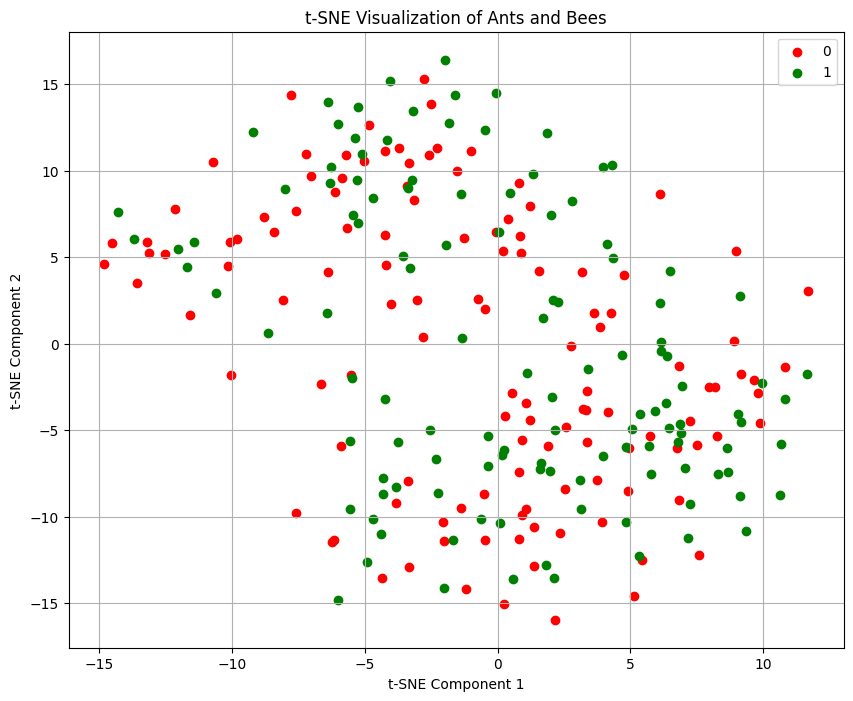

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Compute t-SNE embedding
tsne = TSNE(n_components=2, random_state=42)
tsne_embedding = tsne.fit_transform(features_normalized)

# Extract labels from image_datasets
labels = [label for _, label in image_datasets['train']]

# Color mapping for ants and bees
color_map = {0: 'r', 1: 'g'}  # Assuming ants are labeled as 0 and bees as 1

# Plot t-SNE embedding
plt.figure(figsize=(10, 8))
for label in set(labels):
    indices = [idx for idx, l in enumerate(labels) if l == label]
    plt.scatter(tsne_embedding[indices, 0], tsne_embedding[indices, 1], c=color_map[label], label=f'{label}')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Ants and Bees')
plt.legend()
plt.grid(True)
plt.show()


Here we observe how well-separated or clustered the ants and bees are in the lower-dimensional space. Ideally, we see distinct clusters of red (ants) and green (bees) dots, indicating that the features extracted from the images are discriminative enough to distinguish between the two classes.

Q2 PART A

In [ ]:
from sklearn.decomposition import PCA

# Define the number of components for PCA
n_components = 2  # You can choose the number of components you want to reduce the data to

# Train PCA
pca = PCA(n_components=n_components)
pca.fit(features_normalized)

# Transform the features using the trained PCA
features_pca = pca.transform(features_normalized)

# Print the explained variance ratio for each principal component
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.07762992 0.04788861]


We see that the output indicates that the first two principal components explain a relatively small portion of the total variance in the dataset (around 7.76% and 4.79%, respectively)

part b

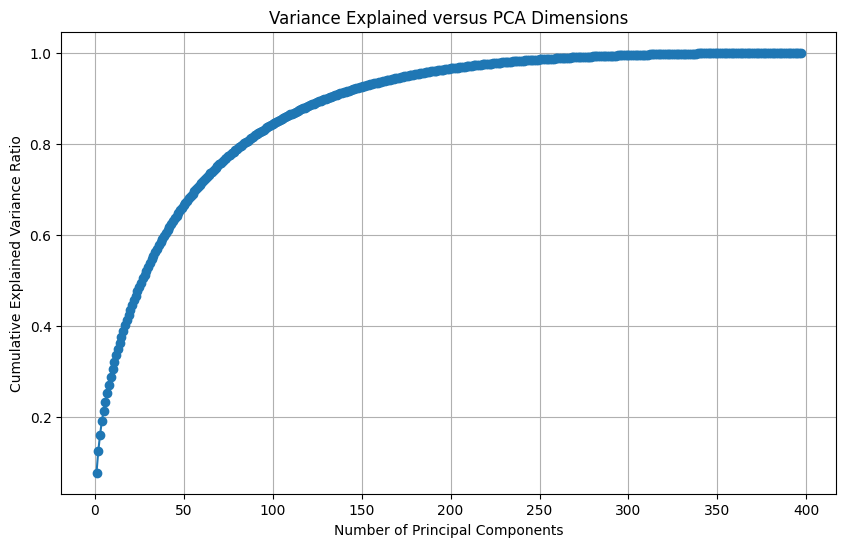

In [ ]:
import matplotlib.pyplot as plt

# Train PCA
pca = PCA()
pca.fit(features_normalized)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot variance explained versus PCA dimensions
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.title('Variance Explained versus PCA Dimensions')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()


Here we have plotted the cumulative explained variance ratio against the number of principal components used in PCA.

This visualizes how much of the total variance in the dataset is explained by adding additional principal components.

PART C

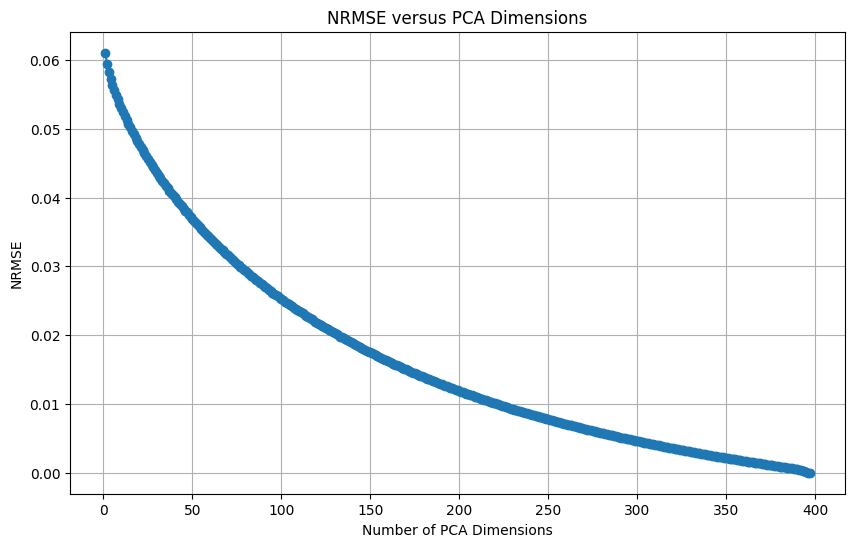

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to compute NRMSE
def compute_nrmse(original_data, reconstructed_data):
    rmse = np.sqrt(mean_squared_error(original_data, reconstructed_data))
    data_range = np.max(original_data) - np.min(original_data)
    nrmse = rmse / data_range
    return nrmse

# Initialize PCA
pca = PCA()

# List to store NRMSE values
nrmse_values = []

# Define the maximum number of PCA components
max_components = min(len(features_normalized), len(features_normalized[0]))

# Loop over different numbers of PCA dimensions
for n_components in range(1, max_components + 1):
    # Train PCA with n_components
    pca.n_components = n_components
    pca.fit(features_normalized)

    # Transform and reconstruct data
    features_reduced = pca.transform(features_normalized)
    reconstructed_features = pca.inverse_transform(features_reduced)

    # Compute NRMSE
    nrmse = compute_nrmse(features_normalized, reconstructed_features)
    nrmse_values.append(nrmse)

# Plot NRMSE versus PCA dimensions
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), nrmse_values, marker='o', linestyle='-')
plt.title('NRMSE versus PCA Dimensions')
plt.xlabel('Number of PCA Dimensions')
plt.ylabel('NRMSE')
plt.grid(True)
plt.show()


OBSERVATION : As we increase the number of PCA dimensions, the NRMSE decreases, indicating better reconstruction of the original data.

Question 3 part a

In [ ]:
from sklearn.decomposition import KernelPCA

# Define the KPCA model
kpca = KernelPCA(n_components=2, kernel='rbf')

# Fit the KPCA model to the normalized features
kpca.fit(features_normalized)

# Transform the features to the KPCA space
features_kpca = kpca.transform(features_normalized)


part b

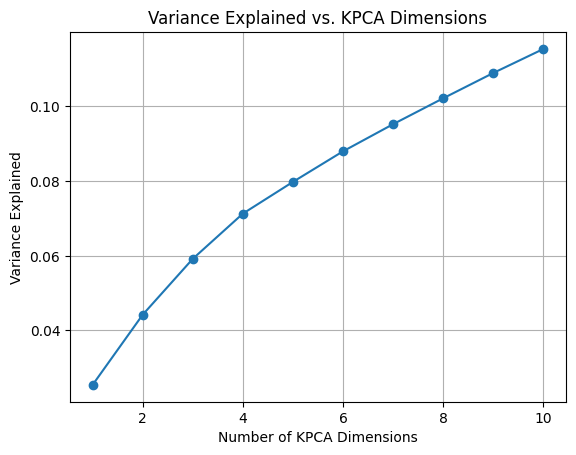

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA

# Define a range of numbers of KPCA dimensions
n_components_range = range(1, 11)

# Initialize an empty list to store the explained variance for each component
explained_variance = []

# Iterate over the range of numbers of KPCA dimensions
for n_components in n_components_range:
    # Define the KPCA model with the specified number of components
    kpca = KernelPCA(n_components=n_components, kernel='rbf')

    # Fit the KPCA model to the normalized features and transform the features
    features_kpca = kpca.fit_transform(features_normalized)

    # Compute the variance explained by each component
    variance_explained = np.var(features_kpca, axis=0)

    # Compute the total variance explained by the selected number of components
    total_variance_explained = np.sum(variance_explained)

    # Store the total variance explained
    explained_variance.append(total_variance_explained)

# Plot the variance explained versus KPCA dimensions
plt.plot(n_components_range, explained_variance, marker='o')
plt.xlabel('Number of KPCA Dimensions')
plt.ylabel('Variance Explained')
plt.title('Variance Explained vs. KPCA Dimensions')
plt.grid(True)
plt.show()


OBSERVATION : As we increase the number of KPCA dimensions, the total variance explained tends to increase.

The plot helps us to determine the optimal number of KPCA dimensions needed to capture most of the variance in the data.

**REFERENCES:**

1. ChatGPT
2. Discussion and doubt solve in class